# Fully Convolutional Network (FCN) for image denoising using the LFWcrop dataset.
# The goal is to investigate the effectiveness of FCN in reducing noise in images.

## Import useful libraries

In [35]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

## Import dataset

In [1]:
!wget -O LFWcrop.zip "https://conradsanderson.id.au/lfwcrop/lfwcrop_color.zip"
!unzip LFWcrop.zip

--2024-07-02 07:11:36--  https://conradsanderson.id.au/lfwcrop/lfwcrop_color.zip
Resolving conradsanderson.id.au (conradsanderson.id.au)... 43.250.142.19, 2400:b800:3:1::1a
Connecting to conradsanderson.id.au (conradsanderson.id.au)|43.250.142.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152404390 (145M) [application/zip]
Saving to: 'LFWcrop.zip'

LFWcrop.zip         100%[===================>] 145.34M  17.6MB/s    in 10s     

2024-07-02 07:11:47 (14.6 MB/s) - 'LFWcrop.zip' saved [152404390/152404390]

Archive:  LFWcrop.zip
   creating: lfwcrop_color/
   creating: lfwcrop_color/lists/
  inflating: lfwcrop_color/lists/07_test_same.txt  
  inflating: lfwcrop_color/lists/06_test_same.txt  
  inflating: lfwcrop_color/lists/06_train_diff.txt  
  inflating: lfwcrop_color/lists/05_test_diff.txt  
  inflating: lfwcrop_color/lists/04_test_same.txt  
  inflating: lfwcrop_color/lists/10_train_diff.txt  
  inflating: lfwcrop_color/lists/07_train_diff.txt  
  inflati

## Load the data

In [9]:
def load_data(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".ppm"):
            img_path = os.path.join(directory, filename)
            image = cv2.imread(img_path)
            images.append(image)

    return images

In [10]:
HOME = os.getcwd()

image_path = f"{HOME}/lfwcrop_color/faces/"
data = load_data(image_path)

## Adding noise to the entire dataset

We generate Gaussian noise with a mean ($\mu$) of 0 and a standard deviation ($\sigma$) equal to 10% of the minimum pixel value of each image. By scaling the standard deviation with the minimum pixel value, we aim to maintain visibility of subtle changes in images with lower pixel intensities, while preventing excessive noise in images with higher pixel intensities.

In [12]:
ndata = []
for img in data:
    mean_pixel_value = np.min(img)
    std = 0.1 * mean_pixel_value
    gaussian = np.random.normal(0, std, size=img.shape).astype(np.uint8)    # astype(np.uint8) to ensure the pixel values are within the valid range [0, 255].
    noisy_img = cv2.add(img, gaussian)
    ndata.append(noisy_img)

## Data splitting and normalization

In [13]:
def split_data(data, test_size=0.3, val_size=0.5, random_state=42):

    train_data, test_val_data = train_test_split(np.array(data), test_size=test_size, random_state=random_state)

    test_data, val_data = train_test_split(test_val_data, test_size=val_size, random_state=random_state)

    # Normalization of each pixel in each data
    train_data = train_data / 255
    test_data = test_data / 255
    val_data = val_data / 255

    return train_data, test_data, val_data

In [14]:
# Normal data
train_data, test_data, val_data = split_data(data)

# Noisy data
ntrain_data, ntest_data, nval_data = split_data(ndata)

## Create the Fully convolutional network model

In [17]:
INPUT_SHAPE = train_data.shape[1:]

In [20]:
def fcn_model():
    # Encoder
    model = keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=INPUT_SHAPE))
    model.add(layers.MaxPooling2D((2, 2), padding="same"))
    model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2, 2), padding="same"))

    # Decoder
    model.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
    model.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
    model.add(layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same"))

    return model

model = fcn_model()

### Breakdown of the code:

`Encoder:`

* Convolutional Layer: Takes the input image (64x64x3) and applies a filter to find patterns, using the ReLU activation function for non-linearity.
* Max Pooling Layer: Reduces the image size by keeping the maximum values in 2x2 regions. This helps focus on important features.
* Another Convolutional Layer: Adds more complexity to the pattern recognition.
* Another Max Pooling Layer: Further reduces the image size.

`Decoder:`

* Transposed Convolutional Layer: Upsamples the features for every 2 pixels, recovering spatial details.
* Another Transposed Convolutional Layer: Further enhances upsampling.
* Convolutional Layer (3 filters, 3x3 kernel, Sigmoid activation): Generates the final output with three filters (representing RGB channels).Sigmoid activation is used to limit the pixel values between 0 and 1.

`Explanation:`

The Encoder extracts features, and the Decoder reconstructs the denoised image.
Conv2DTranspose layers in the Decoder help recreate details lost during downsampling.
Sigmoid activation ensures pixel values stay between 0 and 1.

We think that this architecture is great for denoising as it captures both big and small details in the image. The Transposed Convolutional layers in the Decoder are key for generating a clear and detailed output.

## Model summary

In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,507 (115.26 KB)

 Trainable params: 29,507 (115.26 KB)

 Non-trainable params: 0 (0.00 B)

## Compile model

In [22]:
# Optimizer
opt = Adam()

# Compile model
model.compile(loss = 'mean_squared_error', metrics=['accuracy'], optimizer=opt)

In [23]:
history = model.fit(
    ntrain_data,
    train_data,
    validation_data = (val_data, nval_data),
    epochs=10,
    batch_size=64,
    shuffle=True
)

Epoch 1/10
 13/145 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8160 - loss: 0.0389

I0000 00:00:1719905005.250595     240 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/145 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.9451 - loss: 0.0254 - val_accuracy: 0.8820 - val_loss: 0.0182
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9712 - loss: 0.0038 - val_accuracy: 0.8825 - val_loss: 0.0156
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9746 - loss: 0.0026 - val_accuracy: 0.8864 - val_loss: 0.0155
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9765 - loss: 0.0023 - val_accuracy: 0.8871 - val_loss: 0.0162
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9778 - loss: 0.0020 - val_accuracy: 0.8880 - val_loss: 0.0156
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9783 - loss: 0.0019 - val_accuracy: 0.8885 - val_loss: 0.0155
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9797 - loss: 0.0017 - val_accuracy: 0.8896 - val_loss: 0.0144
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9803 - loss: 0.0016 - val_accuracy: 0.88

## Save the model

In [24]:
model.save('fcn_model.keras')

## Pick some images of our choice

In [65]:
img_index = [19, 23, 40, 56, 61, 67, 75, 90]

## Make prediction

In [66]:
prediction = []
for index in img_index:
    img_pred = model.predict(ntest_data[index].reshape(-1, *INPUT_SHAPE))
    prediction.append(img_pred.reshape(INPUT_SHAPE))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


## Plot the results
The plot showcases three images arranged from top to bottom: the noisy image, the predicted image, and the original image.

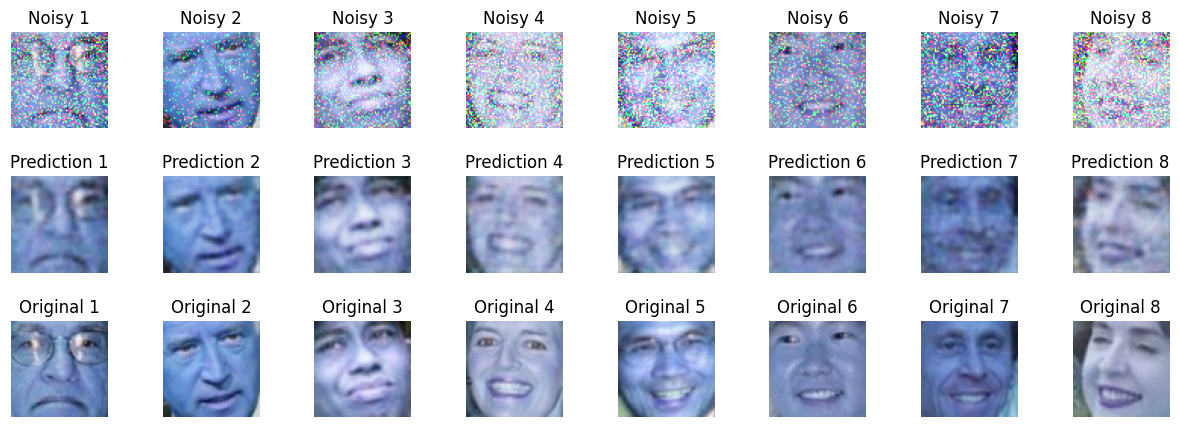

In [70]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
cols = len(img_index)
rows = 3
i = 0
for index in img_index:
    # Noisy image
    plt.subplot(rows, cols, i + 1)
    plt.imshow(ntest_data[index])
    plt.title(f'Noisy {i + 1}')
    plt.axis('off')

    # Predicted image
    plt.subplot(rows, cols, cols + i + 1)
    plt.imshow(prediction[i])
    plt.title(f'Prediction {i + 1}')
    plt.axis('off')

    # Original image
    plt.subplot(rows, cols, 2 * cols + i + 1)
    plt.imshow(test_data[index])
    plt.title(f'Original {i + 1}')
    plt.axis('off')
    i += 1
    
plt.savefig('result.jpg', dpi=300, format='jpg')
plt.show()

## MSE values of each selected images

In [69]:
def calculate_mse(original_image, noisy_image):
    mse_values = {}
    i = 1

    for index in img_index:
        mean = np.mean((original_image[index] - noisy_image[index])**2)

        mse_values[f'image {i}'] = f'mse_values-> {100*mean:.2f}%'
        i += 1
    return mse_values
calculate_mse(test_data, ntest_data)

{'image 1': 'mse_values-> 5.31%',
 'image 2': 'mse_values-> 1.82%',
 'image 3': 'mse_values-> 3.41%',
 'image 4': 'mse_values-> 4.84%',
 'image 5': 'mse_values-> 6.96%',
 'image 6': 'mse_values-> 3.19%',
 'image 7': 'mse_values-> 7.65%',
 'image 8': 'mse_values-> 7.79%'}